# EDSA - Climate Change Belief Analysis 2021

Predict an individual’s belief in climate change based on historical tweet data

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

![climate change](https://images.unsplash.com/photo-1580868636775-b8a1818ca086?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1500&q=80)


## 1. Data Collection
### Importing libraries
First, we'll import the libraries we will need, followed by the data.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re
import string
import unicodedata
import inflect
import contractions
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from nltk.stem import WordNetLemmatizer
import urllib
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import TreebankWordTokenizer

ModuleNotFoundError: No module named 'contractions'

### Reading in the data

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [5]:
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [6]:
train_df.shape

(15819, 3)

In [7]:
train_df.message.dtype

dtype('O')

The shape command shows us that our train data has has 15819 rows of data and 3 features.

In [6]:
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [7]:
test_df.shape

(10546, 2)

In [9]:
# Looking at the numbers of possible classes in our sentiment
train_df['sentiment'].unique()

array([ 1,  2,  0, -1], dtype=int64)

In [11]:
# Looking at the how the messages are distributed across the sentiment
train_df.describe()

,sentiment,tweetid
count,15819.000000,15819.000000
mean,0.917504,501719.433656
std,0.836537,289045.983132
min,-1.000000,6.000000
25%,1.000000,253207.500000
50%,1.000000,502291.000000
75%,1.000000,753769.000000
max,2.000000,999888.000000


## 2. Data Cleaning
Before we clean our data, we need to know what type of data we're working with, does the data contain any missing values, ... etc

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10546 non-null  object
 1   tweetid  10546 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 164.9+ KB


We should now check if our data contains any missing values.

In [10]:
train_df.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [13]:
# Checking whether a character is white-space character or not
print(len(train_df['message']))
print(sum(train_df['message'].apply(lambda x: x.isspace())))

15819
0


In [11]:
test_df.isnull().sum()

message    0
tweetid    0
dtype: int64

In [15]:
# Sample of a  tweet
tweet = train_df.iloc[6,1]
print(tweet)

RT @thenation: Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R


### Removing Noise
Variable `message` contains contains web address, we need to remove them

In [12]:
def incomplete_words(words):
    """
    This function replace all incomplete word with the original version of the word
    For example, `I'll` will become `I will` and `gng
    """
    return contractions.fix(words)

def remove_URL(words):
    """This function take a string as an input and removes any url that are present in that string"""
    
    return re.sub(r"http\S+", "", words)

In [13]:
train_df['message'] = train_df['message'].apply(remove_URL)
test_df['message'] = test_df['message'].apply(remove_URL)

In [14]:
train_df['message'] = train_df['message'].apply(incomplete_words)
test_df['message'] = test_df['message'].apply(incomplete_words)

NameError: name 'contractions' is not defined

### Convert to Lowercase and Remove Punctuation
Our data needs to be consistent, `i.e. Explore and explore is one word`

In [16]:
def remove_punctuations(tokenized_words):
    """This function take a string/list as an input and removes all the punctuations"""
    
    #return ''.join([word for word in tokenized_words if word not in string.punctuation])
    words = str.maketrans('', '', string.punctuation)
    return tokenized_words.translate(words)

def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

def replace_slang(text):       
    return ' '.join([word.replace('rt', '') for word in text.split()])

def remove_non_ascii(tokenized_words):
    """Remove non-ASCII characters from list of tokenized words"""

    return ''.join([unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in tokenized_words])

def to_lowercase(tokenized_words):
    """Convert all characters to lowercase from list of tokenized words"""
    
    return ''.join([word.lower() for word in tokenized_words])

def replace_numbers(tokenized_words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    inflector = inflect.engine()

    return ''.join([inflector.number_to_words(word) if word.isdigit() else word for word in tokenized_words])

def remove_other(text):
    
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

def remove_emoji(words):
    emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"
                u"\U0001F300-\U0001F5FF"
                u"\U0001F680-\U0001F6FF"
                u"\U0001F1E0-\U0001F1FF"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', words)

def clean_text_data(tokenized_words):
    """Clean each word from list of tokenized words"""
    
    tokenized_words = remove_non_ascii(tokenized_words)
    tokenized_words = remove_emoji(tokenized_words)
    tokenized_words = replace_numbers(tokenized_words)
    tokenized_words = to_lowercase(tokenized_words)
    tokenized_words = remove_punctuations(tokenized_words)
    tokenized_words = remove_other(tokenized_words)
    tokenized_words = remove_stopwords(tokenized_words)
    tokenized_words = replace_slang(tokenized_words)
    
    return tokenized_words

In [17]:
train_df['message'] = train_df['message'].apply(clean_text_data)
test_df['message'] = test_df['message'].apply(clean_text_data)

In [18]:
train_df['message'][4]

' soynoviodetodas twozeroonesix racist sexist climate change denying bigot leading polls electionnight'

### Tokenisation

In [19]:
tokeniser = TreebankWordTokenizer()

#train_df['message'] = train_df['message'].apply(tokeniser.tokenize)
#test_df['message'] = test_df['message'].apply(tokeniser.tokenize)

train_df['message'][122]

In [20]:
#def remove_stopwords(tokenized_words):
#    """Remove stop words from list of tokenized words"""
#    no_stopwords = []
    
#    for sentence in tokenized_words:
#        no_stopwords.append([word for word in sentence if word not in stopwords.words('english')])
        
#    return no_stopwords

### Lemmatization
Let's lemmatize all of the words in both train and test dataframe.

In [21]:
lemmatizer = WordNetLemmatizer()

In [22]:
def lemma_(tokenized_words):
    #return [lemmatizer.lemmatize(word) for word in tokenized_words]
    return ' '.join([lemmatizer.lemmatize(word) for word in tokenized_words.split()])

In [23]:
train_df['message'] = train_df['message'].apply(lemma_)
test_df['message'] = test_df['message'].apply(lemma_)

In [24]:
train_df['message'][122]

'stephenschlegel thinking going die husband believe climate change'

## 3. Exploratory Data Analysis (EDA)

In [25]:
sns.set()

In [26]:
train_df.sentiment.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

C:\DSToolkit\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


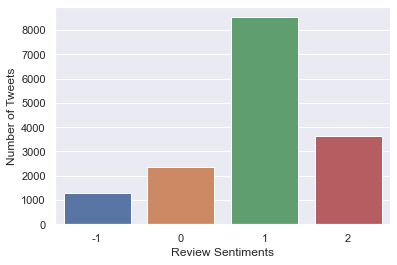

In [27]:
Sentiment_count = train_df.groupby('sentiment').count()

sns.barplot(Sentiment_count.index.values, Sentiment_count['message'])
plt.xlabel('Review Sentiments')
plt.ylabel('Number of Tweets')
plt.show()

Text(0.5, 1.0, 'Distribution of target labels')

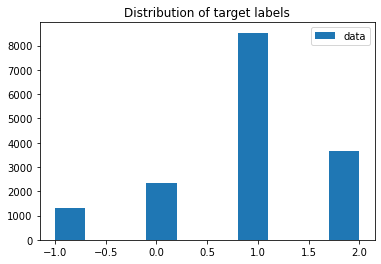

In [21]:
# Visualizing the distribution of the target labels 
plt.hist(train_df['sentiment'], label='data');
plt.legend();
plt.title('Distribution of target labels')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

Text(0, 0.5, 'Density')

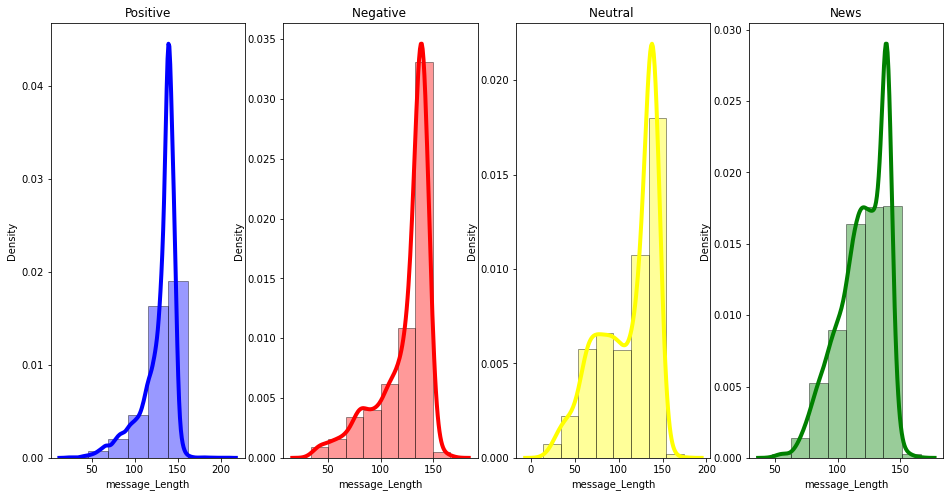

In [33]:
# Distribution plots for the label
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(16,8))

#For Positive 
sns.distplot(train_df[train_df['sentiment']==1]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'blue', 
             ax = ax1,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax1.set_title('Positive')
ax1.set_xlabel('message_Length')
ax1.set_ylabel('Density')

#For Negative 
sns.distplot(train_df[train_df['sentiment']==-1]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'red', 
             ax = ax2,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax2.set_title('Negative ')
ax2.set_xlabel('message_Length')
ax2.set_ylabel('Density')

#For Neutral 
sns.distplot(train_df[train_df['sentiment']==0]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'yellow',  
             ax = ax3,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax3.set_title('Neutral ')
ax3.set_xlabel('message_Length')
ax3.set_ylabel('Density')

#For Neews
sns.distplot(train_df[train_df['sentiment']==2]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'green', 
             ax = ax4,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax4.set_title('News')
ax4.set_xlabel('message_Length')
ax4.set_ylabel('Density')

<AxesSubplot:xlabel='sentiment', ylabel='count'>

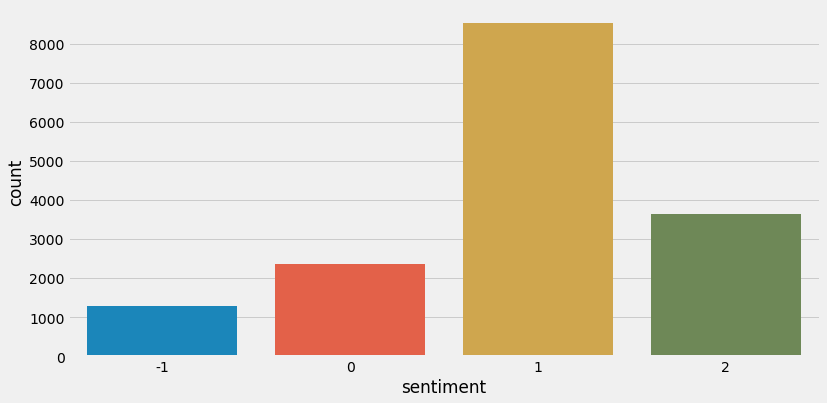

In [60]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train_df)

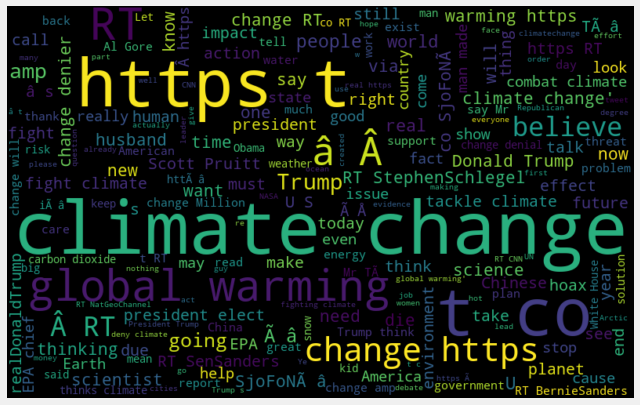

In [76]:
#the word cloud (a visualization where frequent words appear)

all_words = ' '.join([text for text in train_df['message']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [107]:
new_df = train_df.copy()

#Labeling the target
new_df['sentiment'] = [['Negative', 'Neutral', 'Positive', 'News'][x+1] for x in new_df['sentiment']]


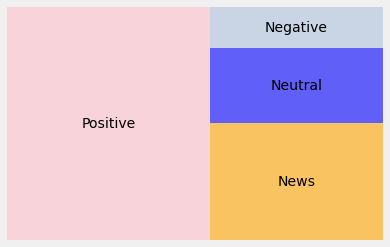

In [109]:
import squarify

# checking the numerical distribution
values = new_df['sentiment'].value_counts()/new_df.shape[0]
labels = (new_df['sentiment'].value_counts()/new_df.shape[0]).index 
colors = ['pink', 'orange', 'blue', 'lightsteelblue']

squarify.plot(sizes=values, label=labels,  color=colors, alpha=0.6)
plt.axis('off')
plt.show()

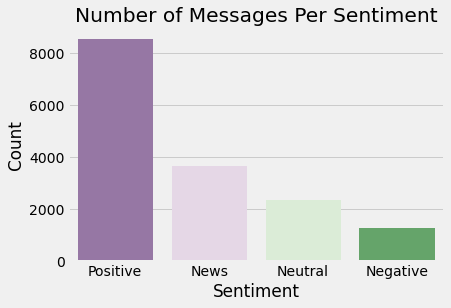

In [111]:
sns.countplot(x='sentiment' ,data = new_df, palette='PRGn')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.title('Number of Messages Per Sentiment')
plt.show()

In [112]:
# Extracting Users in a column
new_df['users'] = [''.join(re.findall(r'@\w{,}', line)) 
                       if '@' in line else np.nan for line in new_df.message]

# Creating a column of hastags
new_df['hashtags'] = [' '.join(re.findall(r'#\w{,}', line)) 
                       if '#' in line else np.nan for line in new_df.message]

In [113]:
# Generating Counts of users
counts = new_df[['message', 'users']].groupby('users', as_index=False).count().sort_values(by='message', ascending=False)

In [114]:
# Top 5 most popular
counts.head()

,users,message
3410,@StephenSchlegel,307
3270,@SenSanders,243
6182,@realDonaldTrump,143
448,@BernieSanders,121
612,@CNN,106


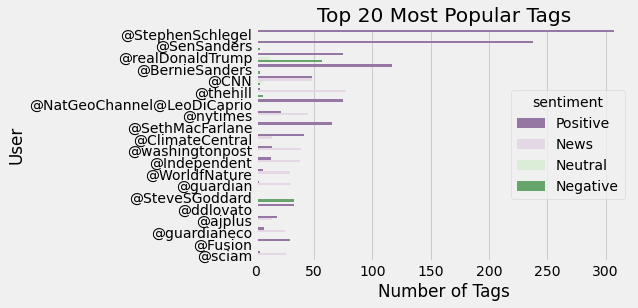

In [115]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(y="users", hue="sentiment", data=new_df, palette='PRGn',
              order=new_df.users.value_counts().iloc[:20].index) 

plt.ylabel('User')
plt.xlabel('Number of Tags')
plt.title('Top 20 Most Popular Tags')
plt.show()
#plt.xticks(rotation=90)

In [96]:

from math import pi
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from pandas import DataFrame
from colorama import Fore, Back, Style
y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA
sr_ = Style.RESET_ALL

In [97]:
from bokeh.io import output_notebook
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.transform import cumsum
from bokeh.palettes import Spectral6
from bokeh.models import ColumnDataSource
from bokeh.layouts import gridplot
from bokeh.io import curdoc

In [105]:
different_languages = train_df['sentiment'].value_counts().keys().to_list()
count = train_df['sentiment'].value_counts().values
count1 = count / sum(count) * 100
angle = count / sum(count) * 2 * pi

source = ColumnDataSource(data = dict(types = different_languages, count = count, color = ['skyblue', 'salmon', 'turquoise', 'red', 'lightseagreen'], angle = angle, percentage = count1))

p4 = figure(plot_height = 400, plot_width = 400, title = "Proportion of Article Languages",
           tools = "hover", tooltips = "@types: @percentage", x_range = (-1.0, 1.0))  ## Pie chart for different article languages

p4.wedge(x = 0, y = 1, radius = 0.8,
        start_angle = cumsum('angle', include_zero = True), end_angle = cumsum('angle'),
        line_color = "white", fill_color = 'color', legend_field = 'types', source = source)
p4.title.align = 'center'

p4.legend.location = "top_right"

p4.legend.label_text_font_size = '5pt'

show(p4)


## 4. Feature Engineering
We have seen from the EDA that 

## 5. Model Building
### Feature Generation using Bag of Words

In [28]:
train = train_df.copy()
test = test_df.copy()

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
#tokenizer to remove unwanted elements from out data like symbols and numbers

cv = CountVectorizer(stop_words = 'english', ngram_range = (1,1), tokenizer = tokeniser.tokenize)
X = cv.fit_transform(train['message'])
y = train['sentiment'].values

print("X shape : ", X.shape)
print("y shape : ", y.shape)

X shape :  (15819, 23516)
y shape :  (15819,)


### Split train and test set

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

### Model Building and Evaluation

In [35]:
from sklearn.naive_bayes import MultinomialNB

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted = clf.predict(X_test)

print("MultinomialNB Testing Accuracy Score: ", accuracy_score(y_test, predicted))
print("MultinomialNB Training Accuracy Score: ", clf.score(X_train, y_train))
print(classification_report(predicted, y_test))

MultinomialNB Testing Accuracy Score:  0.7039612305099031
MultinomialNB Training Accuracy Score:  0.8505373430867876
              precision    recall  f1-score   support

          -1       0.26      0.69      0.38       137
           0       0.29      0.63      0.39       319
           1       0.88      0.72      0.79      3168
           2       0.72      0.69      0.70      1122

    accuracy                           0.70      4746
   macro avg       0.53      0.68      0.57      4746
weighted avg       0.78      0.70      0.73      4746



## 6. Model Deployment
### Saving a model with Pickle

In [36]:
import pickle

model_save_path = "clf.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(clf, file)

### Preprocessing: Predicting on the test set
Preprocessing
The first thing we need to do is to get our data in the correct format. We will use the same techniques we used when preparing the training data to ensure we do not get any errors.

In [39]:
tweet_id = test['tweetid']
X_test_ = cv.transform(test['message'].values)

In [41]:
X_test_.shape

(10546, 23516)

### Making predictions

In [42]:
preds = clf.predict(X_test_)

In [44]:
preds

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

### Submission

In [45]:
# create submission dataframe
submission = pd.DataFrame(
    {'tweetid': tweet_id,
     'sentiment': preds
    })

In [46]:
# save DataFrame to csv file for submission
submission.to_csv("Classification_AM1_DSFT21.csv", index=False)

## Conclusion

## Appendix